In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n, m = x_train.shape
nh = 50
c = y_train.max() + 1

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def forward(self, x):
        for l in self.layers : x = l(x)
        return x

In [7]:
model = Model(m, nh, 10)

In [8]:
pred = model(x_train)

In [9]:
def log_softmax(x): return (x.exp()/x.exp().sum(-1, keepdim=True)).log()

In [10]:
sm_pred = log_softmax(pred)

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[0][5]

tensor(-2.2625, grad_fn=<SelectBackward>)

In [13]:
sm_pred[[0, 1, 2],[5, 0, 4]]

tensor([-2.2625, -2.2718, -2.3811], grad_fn=<IndexBackward>)

In [14]:
y_train.shape

torch.Size([50000])

In [15]:
def nll(input, target): return -input[range(input.shape[0]), target].mean()

In [16]:
loss = nll(sm_pred, y_train)

In [17]:
loss

tensor(2.3145, grad_fn=<NegBackward>)

In [18]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [19]:
test_near(nll(log_softmax(pred), y_train), loss)

In [20]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:,None]).exp().sum(-1).log()

In [21]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [22]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [23]:
test_near(nll(log_softmax(pred), y_train), loss)

In [24]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [25]:
test_near(F.cross_entropy(pred, y_train), loss)

In [26]:
loss_func = F.cross_entropy

In [27]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [28]:
bs = 64
xb = x_train[:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.1164, -0.0778, -0.0486,  0.1981, -0.1151,  0.0158,  0.0895, -0.0716,
         -0.0312, -0.1371], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [29]:
yb = y_train[:bs]
loss_func(preds, yb)

tensor(2.3265, grad_fn=<NllLossBackward>)

In [30]:
accuracy(preds, yb)

tensor(0.0469)

In [31]:
lr = 0.5
epochs = 1

In [32]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]
        loss = loss_func(model(xb), yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [33]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0405, grad_fn=<NllLossBackward>), tensor(1.))

In [36]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [37]:
model = Model(m, nh, 10)

In [38]:
for name, l in model.named_children(): print(f"{name}:{l}")

l1:Linear(in_features=784, out_features=50, bias=True)
l2:Linear(in_features=50, out_features=10, bias=True)


In [39]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [40]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [41]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i   = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i: end_i]
            loss = loss_func(model(xb), yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [42]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1236, grad_fn=<NllLossBackward>), tensor(0.9375))

In [53]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f"{self._modules}"
        
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [54]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [55]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [58]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [61]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [62]:
model = Model(layers)

In [63]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [66]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [67]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [68]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0753, grad_fn=<NllLossBackward>), tensor(1.))

In [69]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [70]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1892, grad_fn=<NllLossBackward>), tensor(0.9375))

In [71]:
class Optimizer():
    def __init__(self, parameters, lr):
        self.parameters, self.lr = list(parameters), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.parameters: p -= p.grad * lr
                
    def zero_grad(self):
        for p in self.parameters: p.grad.data.zero_()

In [72]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [74]:
optim = Optimizer(model.parameters(), 0.5)

In [76]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        loss = loss_func(model(xb), yb)
        loss.backward()
        optim.step()
        optim.zero_grad()

In [77]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1673, grad_fn=<NllLossBackward>), tensor(0.9375))

In [78]:
#export 

from torch import optim

In [81]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [82]:
model, opt = get_model()

In [83]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [84]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb),yb)
loss, acc

(tensor(0.4469, grad_fn=<NllLossBackward>), tensor(0.9375))

In [88]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [89]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [90]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [91]:
model, opt = get_model()

In [93]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs:i*bs+bs]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [94]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

In [95]:
loss, acc

(tensor(0.0301, grad_fn=<NllLossBackward>), tensor(1.))

In [97]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i: i+self.bs]

In [98]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [99]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

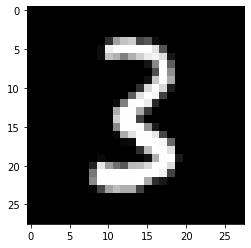

In [104]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [105]:
model, opt = get_model()

In [108]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [111]:
fit()

In [113]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss, acc

(tensor(0.1430, grad_fn=<NllLossBackward>), tensor(0.9844))

In [122]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [123]:
small_ds = Dataset(*train_ds[:10])

In [124]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [125]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([7, 5, 1]), tensor([9, 4, 0]), tensor([3, 6, 2]), tensor([8])]

In [133]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn = collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [134]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [135]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

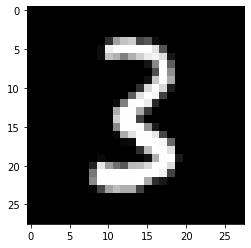

In [136]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(5)

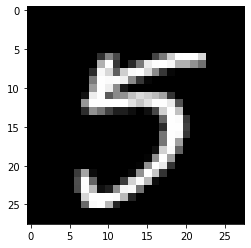

In [140]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [141]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1531, grad_fn=<NllLossBackward>), tensor(0.9688))

In [142]:
#export
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [144]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [145]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.5298, grad_fn=<NllLossBackward>), tensor(0.7812))

In [146]:
train_dl = DataLoader(train_ds, bs, shuffle=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [147]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.6036, grad_fn=<NllLossBackward>), tensor(0.7812))

In [158]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv
            
            

In [159]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [160]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.3723) tensor(0.8960)
1 tensor(0.1176) tensor(0.9668)
2 tensor(0.1116) tensor(0.9684)
3 tensor(0.1580) tensor(0.9557)
4 tensor(0.0974) tensor(0.9740)
